In [1]:
# Classification Project: Rain in Australia
# The dataset from Kaggle contains daily weather observations from various Australian locations. 
# Features include temperature, rainfall, sunshine, wind gusts, humidity and pressure. 
# The goal of this project is to build three models (Clssification Trees, Random Forests, Gradient Boosting) to predict the RainTomorrow target variable.


In [2]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import random
import csv
import statistics
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import roc_curve, auc

In [3]:
# Data loading and initial inspection, understanding the structure of dataset and identifing numerical and categorical features.

rainAUS = pd.read_csv("/Users/aleksandra/Desktop/MachineLearning2/weatherAUS.csv")
print(rainAUS.head())
print(rainAUS.dtypes.value_counts())

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

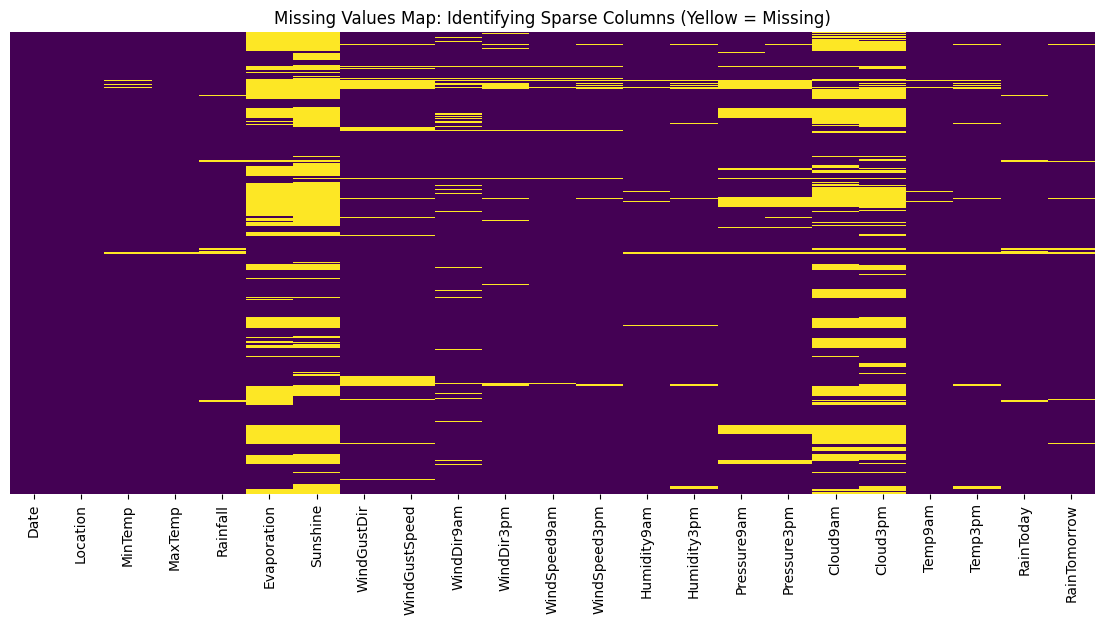

         Date Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed  \
0  2008-12-01   Albury     13.4     22.9       0.6           W           44.0   
1  2008-12-02   Albury      7.4     25.1       0.0         WNW           44.0   
2  2008-12-03   Albury     12.9     25.7       0.0         WSW           46.0   
3  2008-12-04   Albury      9.2     28.0       0.0          NE           24.0   
4  2008-12-05   Albury     17.5     32.3       1.0           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          W        WNW          20.0          24.0         71.0         22.0   
1        NNW        WSW           4.0          22.0         44.0         25.0   
2          W        WSW          19.0          26.0         38.0         30.0   
3         SE          E          11.0           9.0         45.0         16.0   
4        ENE         NW           7.0          20.0         82.0         33.0   

   Pressure9am  Pressure3p

In [4]:
#Variables with very high proportions of missing values (above 40%) are excluded to avoid noise from excessive imputation


plt.figure(figsize=(14, 6))
# Heatmap of missing values: Yellow lines indicate missing data
sns.heatmap(rainAUS.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Map: Identifying Sparse Columns (Yellow = Missing)')
plt.show() 
rainAUS.isna().mean() * 100
rainAUS = rainAUS.drop(columns=["Evaporation", "Sunshine", "Cloud9am", "Cloud3pm"])
print(rainAUS.head())



In [5]:
# Data type distribution and missing values

print("Frequency of data type")
rainAUS.dtypes.value_counts()
print(rainAUS.head())
print(rainAUS.isna().sum())
rainAUS = rainAUS.dropna(subset=["RainTomorrow"])


Frequency of data type
         Date Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed  \
0  2008-12-01   Albury     13.4     22.9       0.6           W           44.0   
1  2008-12-02   Albury      7.4     25.1       0.0         WNW           44.0   
2  2008-12-03   Albury     12.9     25.7       0.0         WSW           46.0   
3  2008-12-04   Albury      9.2     28.0       0.0          NE           24.0   
4  2008-12-05   Albury     17.5     32.3       1.0           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  \
0          W        WNW          20.0          24.0         71.0         22.0   
1        NNW        WSW           4.0          22.0         44.0         25.0   
2          W        WSW          19.0          26.0         38.0         30.0   
3         SE          E          11.0           9.0         45.0         16.0   
4        ENE         NW           7.0          20.0         82.0         33.0   

   

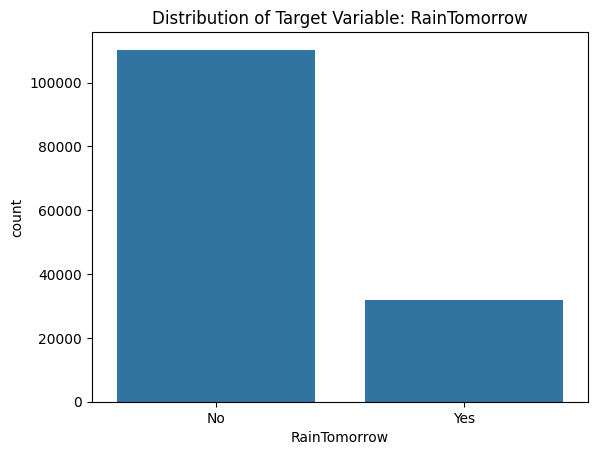

RainTomorrow
No     77.581878
Yes    22.418122
Name: proportion, dtype: float64

In [6]:
# Target variable analysis - distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="RainTomorrow", data=rainAUS)
plt.title("Distribution of Target Variable: RainTomorrow")
plt.show()

# Percantage distribution 

rainAUS["RainTomorrow"].value_counts(normalize=True) * 100



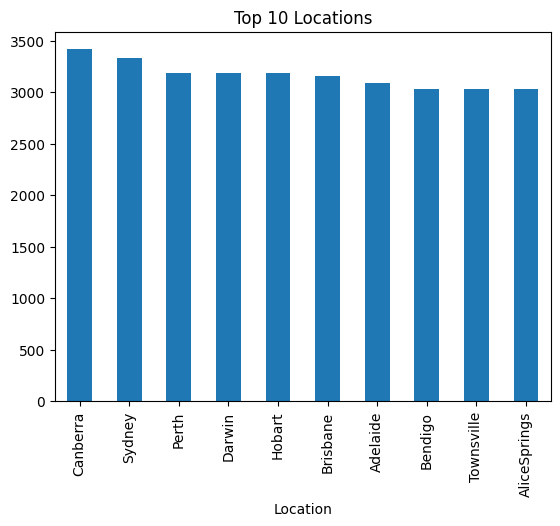

In [7]:
rainAUS["Location"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Locations")
plt.show()

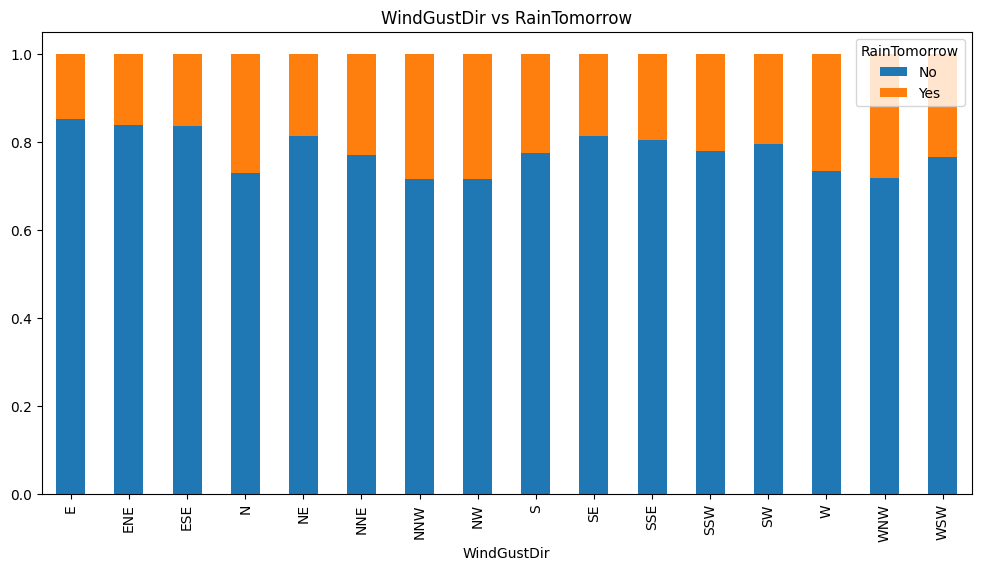

In [8]:
pd.crosstab(rainAUS["WindGustDir"], rainAUS["RainTomorrow"], normalize="index").plot(
    kind="bar", stacked=True, figsize=(12,6)
)
plt.title("WindGustDir vs RainTomorrow")
plt.show()


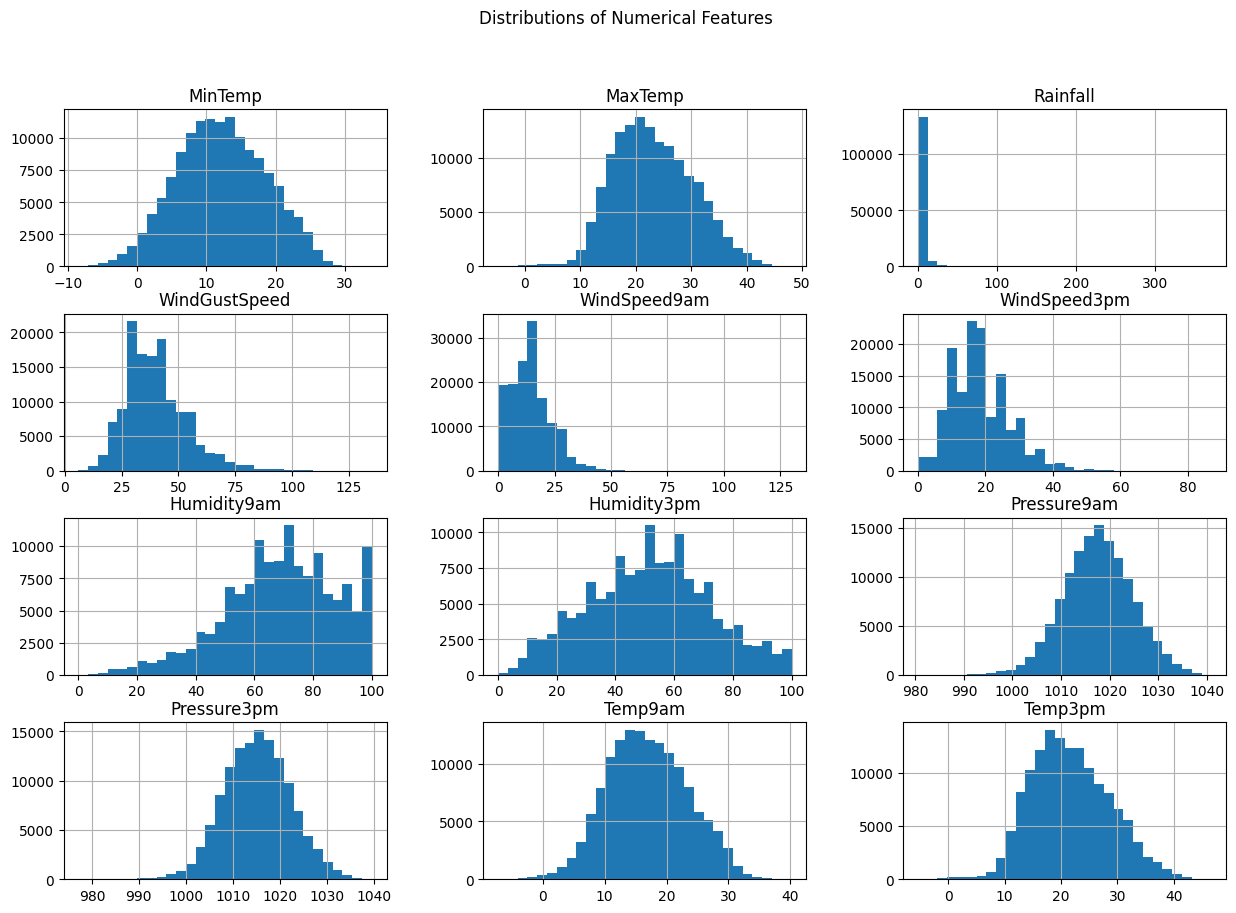

In [9]:
num_cols = rainAUS.select_dtypes(include="number").columns

rainAUS[num_cols].hist(bins=30, figsize=(15,10))
plt.suptitle("Distributions of Numerical Features")
plt.show()

# Temperature and pressure variables exhibit approximately normal distributions, while rainfall and wind-related variables are 
# strongly right-skewed, reflecting the presence of rare extreme events. Humidity variables are concentrated at higher values, 
# indicating potential predictive relevance for rainfall occurrence. The diversity of distributional shapes and the presence of 
#skewness motivate the use of tree-based classification models, which are robust to non-normality and outliers.


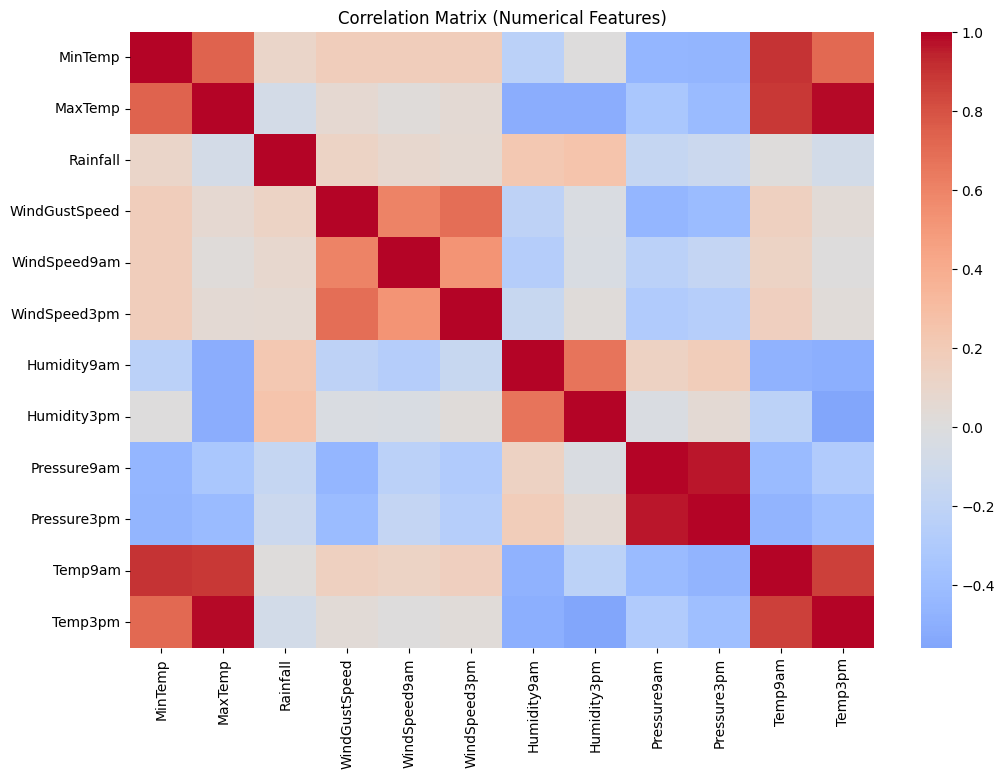

In [10]:
num_cols = rainAUS.select_dtypes(include="number").columns

plt.figure(figsize=(12,8))
sns.heatmap(
    rainAUS[num_cols].corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

# Temperature and Humidity - negative correlations (expected meteorologically)


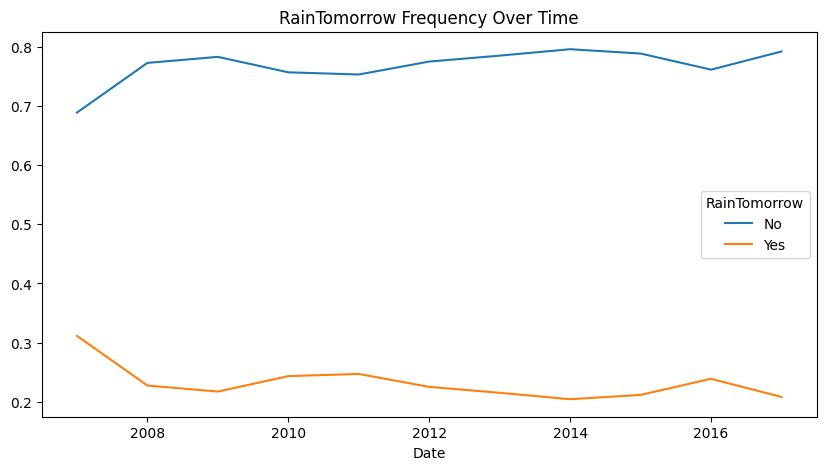

In [11]:
rainAUS["Date"] = pd.to_datetime(rainAUS["Date"])
rainAUS.groupby(rainAUS["Date"].dt.year)["RainTomorrow"].value_counts(normalize=True)\
  .unstack().plot(figsize=(10,5))
plt.title("RainTomorrow Frequency Over Time")
plt.show()



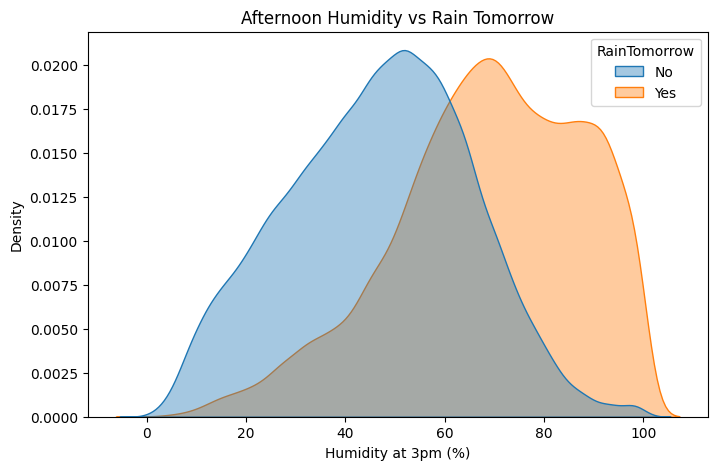

In [12]:
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=rainAUS,
    x="Humidity3pm",
    hue="RainTomorrow",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("Afternoon Humidity vs Rain Tomorrow")
plt.xlabel("Humidity at 3pm (%)")
plt.show()

#Rain rarely comes suddenly — the atmosphere is already saturated the day before. Days before rain have clearly higher afternoon humidity.


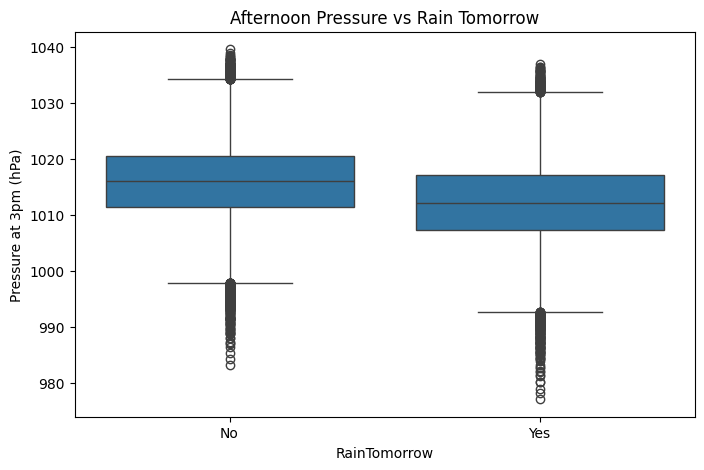

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=rainAUS,
    x="RainTomorrow",
    y="Pressure3pm"
)
plt.title("Afternoon Pressure vs Rain Tomorrow")
plt.ylabel("Pressure at 3pm (hPa)")
plt.show()

# Rainy days tomorrow are preceded by lower pressure. This matches meteorogical theory (low-pressure systems).
# Falling pressure is an early sign of incoming rain. 


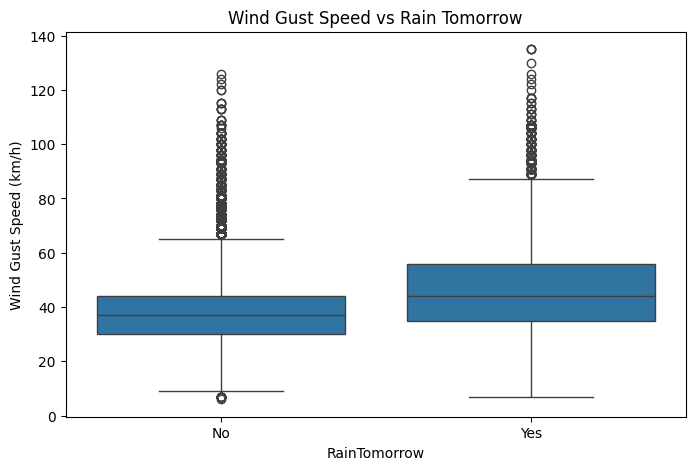

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=rainAUS,
    x="RainTomorrow",
    y="WindGustSpeed"
)
plt.title("Wind Gust Speed vs Rain Tomorrow")
plt.ylabel("Wind Gust Speed (km/h)")
plt.show()

# Wind strenghtens before rain. Extreme values are more frequent. 


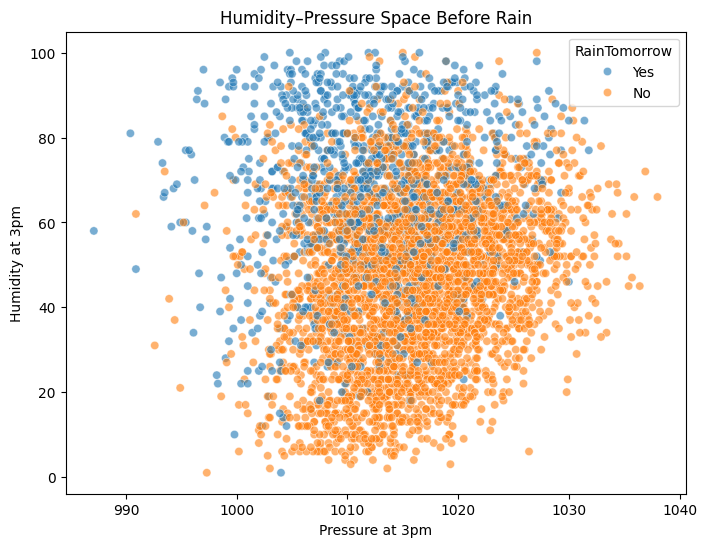

In [15]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rainAUS.sample(5000, random_state=42),
    x="Pressure3pm",
    y="Humidity3pm",
    hue="RainTomorrow",
    alpha=0.6
)
plt.title("Humidity–Pressure Space Before Rain")
plt.xlabel("Pressure at 3pm")
plt.ylabel("Humidity at 3pm")
plt.show()


In [16]:
# Dataset is divided into input features ('X') and the target variable ('y).
# All explanatory variables are ssigned to X, while 'RainTomorrow' is isolated as the response variable to be predicted.

X = rainAUS.drop(columns="RainTomorrow")
y = rainAUS["RainTomorrow"]

In [17]:
# Target variable encoding - 'RainTomorrow' is converted into binary numerical format. 
# The labels *No* and *Yes* are mapped to 0 and 1 - where 1 indicates the occurrence of rainfall.

y = y.map({"No": 0, "Yes": 1})

In [18]:
# New features representing the year, month, and day are derived from the original date in order to capture
# potential seasonal and time-related patterns in rainfall occurrence. The original `Date` column is then removed.

X["Date"] = pd.to_datetime(X["Date"])
X["Year"] = X["Date"].dt.year
X["Month"] = X["Date"].dt.month
X["Day"] = X["Date"].dt.day

X = X.drop(columns="Date")

In [19]:
# Separating numerical and categorical variables

from sklearn.impute import SimpleImputer
num_cols = X.select_dtypes(include="number").columns
cat_cols = X.select_dtypes(include="object").columns



In [20]:
# Handling missing values - categorical variables are imputed usnig the most frequent value, while numerical ones with median. 
# No missing values - suitable for model training. 

cat_imputer = SimpleImputer(strategy="most_frequent")
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

num_imputer = SimpleImputer(strategy="median")
X[num_cols] = num_imputer.fit_transform(X[num_cols])

In [21]:
#One-hot encoding 
# cateogorical features are transformed into numerical format using one-hot encoding. Each category is now represented as binary indicatr varaibel 
# allowing machine learning algorithms to process categorical information.


X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print(X.head())


   MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0     13.4     22.9       0.6           44.0          20.0          24.0   
1      7.4     25.1       0.0           44.0           4.0          22.0   
2     12.9     25.7       0.0           46.0          19.0          26.0   
3      9.2     28.0       0.0           24.0          11.0           9.0   
4     17.5     32.3       1.0           41.0           7.0          20.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  ...  WindDir3pm_NW  \
0         71.0         22.0       1007.7       1007.1  ...          False   
1         44.0         25.0       1010.6       1007.8  ...          False   
2         38.0         30.0       1007.6       1008.7  ...          False   
3         45.0         16.0       1017.6       1012.8  ...          False   
4         82.0         33.0       1010.8       1006.0  ...           True   

   WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  WindDir3pm_SW  \

In [22]:
# All variables are now bool or float64 type. There are no missing values.

print("Frequency of data type")
print(X.dtypes.value_counts())

print(y.isna().sum())

Frequency of data type
bool       94
float64    15
Name: count, dtype: int64
0


In [23]:
# TRAIN-TEST SPLIT and DECISION TREE MODEL TRAINING 
# Data is split into training and test set (80% of the observations used for training)

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
)


# A Decision Tree classifier is then initialized with constraints on tree depth and minimum leaf size to reduce overfitting.


tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)

tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, random_state=42)

In [24]:
# Model evaluation and generating predictions on the test set. Model performance is evaluated using confusion matrix adn classification report
# 

from sklearn.metrics import classification_report, confusion_matrix

y_pred = tree.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[21090   928]
 [ 3730  2691]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     22018
           1       0.74      0.42      0.54      6421

    accuracy                           0.84     28439
   macro avg       0.80      0.69      0.72     28439
weighted avg       0.83      0.84      0.82     28439



In [25]:
# Re-trained with class weights set to balances in order to adress th imbalance between rainy and non-rainy days.
# Re-evaluating on the test set using same metrics. 

tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)
tree.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix

y_pred = tree.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# This model misses far fewer rainy days, which is the main objective of this forecast
# The balanced Decision Tree provides a more appropriate model for rainfall prediction by prioritising the reduction of false negatives over maximising accuracy.

[[17266  4752]
 [ 1774  4647]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     22018
           1       0.49      0.72      0.59      6421

    accuracy                           0.77     28439
   macro avg       0.70      0.75      0.71     28439
weighted avg       0.81      0.77      0.78     28439



In [26]:
# RANDOM FOREST MODEL TRAINING AND EVALUATION

# Class weights are set to balanced to address the class imbalance and to
# prioritise correct identification of rainy days. Hyperparameters such as the number of trees, maximum depth,
# and minimum leaf size are chosen to control model complexity and reduce overfitting.
# The trained model is evaluated on the test set using a confusion matrix and a classification report to assess its performance.

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train) 

from sklearn.metrics import classification_report, confusion_matrix

y_pred_rf = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



[[17557  4461]
 [ 1685  4736]]
              precision    recall  f1-score   support

           0       0.91      0.80      0.85     22018
           1       0.51      0.74      0.61      6421

    accuracy                           0.78     28439
   macro avg       0.71      0.77      0.73     28439
weighted avg       0.82      0.78      0.80     28439



In [27]:
# GRADIENT BOOSTING MODEL TRAINING AND EVALUATION
# Model performance is first evaluated using the default classification threshold. Subsequently, predicted
# probabilities are used to adjust the decision threshold to 0.3 in order to further reduce false negatives and
# improve recall for the rainfall class. The impact of this threshold adjustment is assessed using a classification report.


from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)

from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(
    class_weight="balanced",
    y=y_train
)

gb.fit(X_train, y_train, sample_weight=sample_weights)

y_pred_gb = gb.predict(X_test)

print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

y_prob_gb = gb.predict_proba(X_test)[:, 1]
y_pred_gb = (y_prob_gb > 0.3).astype(int)

print(classification_report(y_test, y_pred_gb))



[[17674  4344]
 [ 1619  4802]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     22018
           1       0.53      0.75      0.62      6421

    accuracy                           0.79     28439
   macro avg       0.72      0.78      0.74     28439
weighted avg       0.83      0.79      0.80     28439

              precision    recall  f1-score   support

           0       0.95      0.59      0.73     22018
           1       0.39      0.90      0.54      6421

    accuracy                           0.66     28439
   macro avg       0.67      0.74      0.64     28439
weighted avg       0.82      0.66      0.69     28439



In [28]:
# COMPARISON 


models = {
    "Decision Tree": tree,
    "Random Forest": rf,
    "Gradient Boosting": gb
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(
        name,
        "Recall (rain):", recall_score(y_test, y_pred),
        "F1 (rain):", f1_score(y_test, y_pred)
    )


Decision Tree Recall (rain): 0.7237190468774334 F1 (rain): 0.5874841972187105
Random Forest Recall (rain): 0.7375798162280018 F1 (rain): 0.6064797029069023
Gradient Boosting Recall (rain): 0.7478585890048279 F1 (rain): 0.6169461039378171


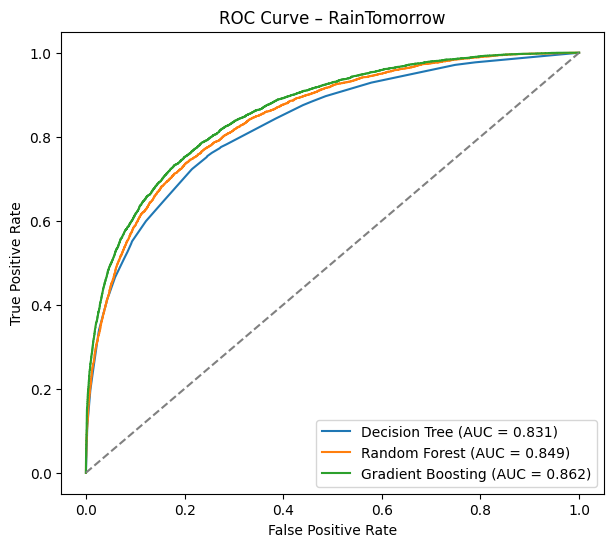

In [29]:
models = {
    "Decision Tree": tree,
    "Random Forest": rf,
    "Gradient Boosting": gb
}

plt.figure(figsize=(7,6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – RainTomorrow")
plt.legend()
plt.show()

# the ROC analysis confirms that ensemble methods outperform a single tree, with Gradient Boosting being the most 
# reliable model for rainfall prediction, particularly when probability-based threshold tuning is applied.


In [30]:
# Comparing the classification performance of a Decision Tree, Random Forest, and Gradient Boosting model using confusion matrices.

# Decision Tree
y_pred_dt = tree.predict(X_test)

# Random Forest
y_pred_rf = rf.predict(X_test)

# Gradient Boosting (threshold = 0.3)
y_prob_gb = gb.predict_proba(X_test)[:, 1]
y_pred_gb = (y_prob_gb > 0.3).astype(int)


In [31]:
def plot_confusion(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_pct = cm / cm.sum() * 100

    labels = np.array([
        [f"TN\n{cm[0,0]:,}\n{cm_pct[0,0]:.1f}%",
         f"FP\n{cm[0,1]:,}\n{cm_pct[0,1]:.1f}%"],
        [f"FN\n{cm[1,0]:,}\n{cm_pct[1,0]:.1f}%",
         f"TP\n{cm[1,1]:,}\n{cm_pct[1,1]:.1f}%"]
    ])

    sns.heatmap(
        cm,
        annot=labels,
        fmt="",
        cmap="Greens",
        cbar=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")


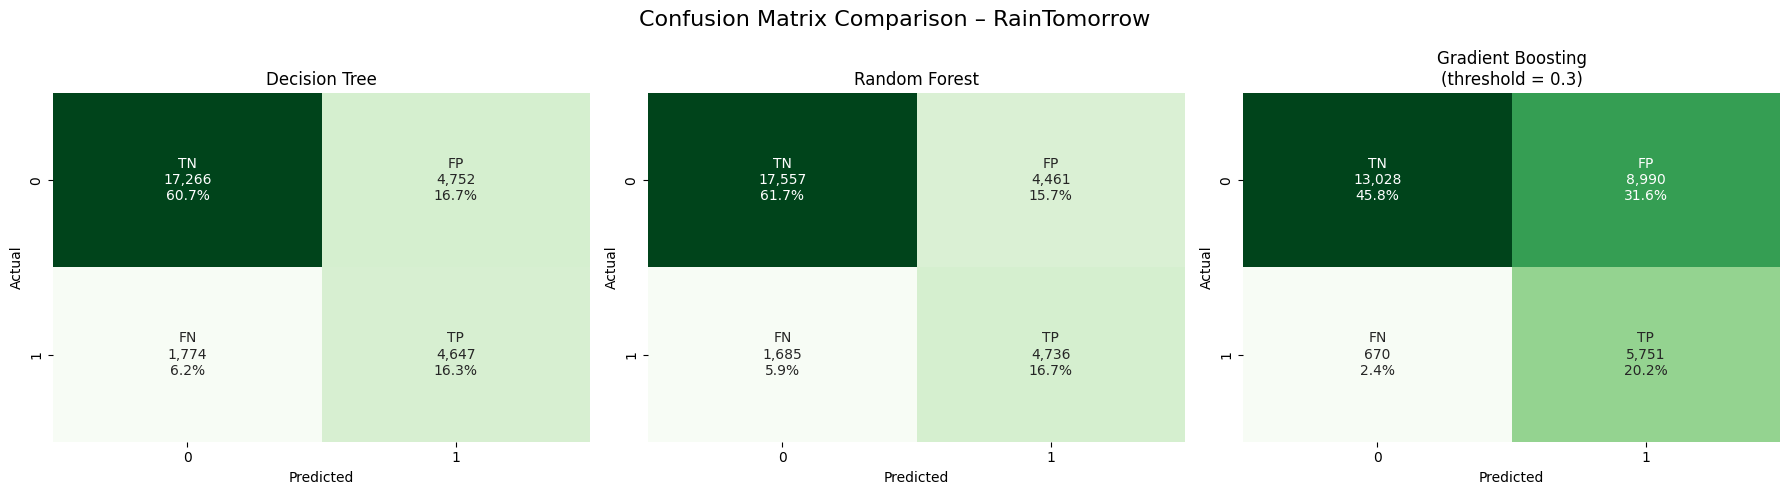

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_confusion(
    axes[0],
    y_test,
    y_pred_dt,
    "Decision Tree"
)

plot_confusion(
    axes[1],
    y_test,
    y_pred_rf,
    "Random Forest"
)

plot_confusion(
    axes[2],
    y_test,
    y_pred_gb,
    "Gradient Boosting\n(threshold = 0.3)"
)

plt.suptitle("Confusion Matrix Comparison – RainTomorrow", fontsize=16)
plt.tight_layout()
plt.show()


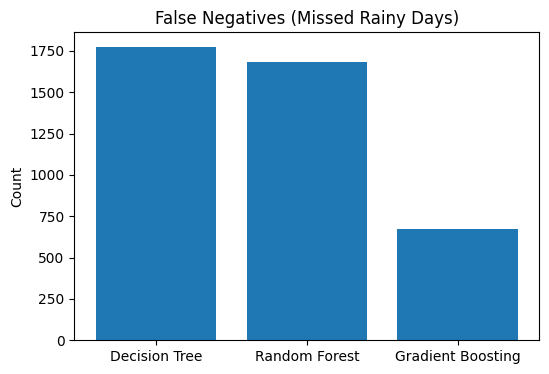

In [33]:
# FN comparison bar chart 

fn_counts = {
    "Decision Tree": confusion_matrix(y_test, y_pred_dt)[1,0],
    "Random Forest": confusion_matrix(y_test, y_pred_rf)[1,0],
    "Gradient Boosting": confusion_matrix(y_test, y_pred_gb)[1,0]
}

plt.figure(figsize=(6,4))
plt.bar(fn_counts.keys(), fn_counts.values())
plt.title("False Negatives (Missed Rainy Days)")
plt.ylabel("Count")
plt.show()

# visually says that Gradient Boosting is the best
# why?
# False Negatives = model is predicting "No Rain", but in reality it rains.
# Missing rain is far more costly than prediciting the rain that does not occur.
# In rainfall prediction, false negatives are the most critical error because failing 
# to predict rain leads to higher real-world costs and risks than issuing a false rain warning.

In [ ]:
# CONCLUSIONS
# The ROC curves show that ensemble methods (Random Forest and Gradient Boosting) clearly outperform the single Decision Tree.
# False Negative analysis highlights that Gradient Boosting produces the fewest missed rainy days — making it the most reliable for warnings and forecasts where missing a rain event has high cost.
# The Gradient Boosting model achieves the best trade-off between precision and recall, with the highest ROC-AUC and lowest false negative count.

# The Gradient Boosting Classifier is the most suitable model for rainfall classification.
#It provides:

#The best overall predictive performance (highest ROC-AUC and F1-score).
#The best recall for rain predictions (fewest missed rainy days).
#Robustness against class imbalance when threshold tuning and sample weighting are applied.
#Thus, it is the recommended model for deployment in a rainfall prediction or weather-alert system.